In [133]:
#REAL stuff
import sys
sys.path.append("../")

import os
import sys
import torch
import argparse
from torch.optim.adamw import AdamW
from models.model_factory import ModelFactory
from training.cost_functions import BinaryGeneralizeDiceLossV2

# Load backbone

In [2]:
model = ModelFactory().get("PrunedConvnextSmall").to('cuda')
checkpoint_path = "../../data/saved_models/convnext_small/best_model_convnext_small.ckpt"
model.load_state_dict(
    torch.load(checkpoint_path,
               map_location="cuda"))

2022-05-15 11:01:18.948 | DEBUG    | models.model_convnext:_getter:155 - Loadin weights from : saved_models/torch/convnext/convnext_small-0c510722.pth
2022-05-15 11:01:23.743 | DEBUG    | models.model_convnext:_getter:160 - Missing Keys: ['transpose_block1.0.weight', 'transpose_block1.0.bias', 'transpose_block1.1.weight', 'transpose_block1.1.bias', 'transpose_block1.1.running_mean', 'transpose_block1.1.running_var', 'transpose_block2.0.weight', 'transpose_block2.0.bias', 'transpose_block2.1.weight', 'transpose_block2.1.bias', 'transpose_block2.1.running_mean', 'transpose_block2.1.running_var', 'transpose_block3.0.weight', 'transpose_block3.0.bias', 'transpose_block3.1.weight', 'transpose_block3.1.bias', 'transpose_block3.1.running_mean', 'transpose_block3.1.running_var', 'transpose_block4.0.weight', 'transpose_block4.0.bias', 'transpose_block4.1.weight', 'transpose_block4.1.bias', 'transpose_block4.1.running_mean', 'transpose_block4.1.running_var', 'transpose_block5.0.weight', 'transpo

<All keys matched successfully>

In [3]:
from utils.datautil import (DataLoaderUtilFactory)

In [4]:
train_loader, val_loader, test_loader \
            = DataLoaderUtilFactory() \
            .get("VanillaDataLoaderUtil", config=None) \
            .get_data_loaders(root_dir="/home/jovyan/work/cil/data/",
                              batch_size=50,
                              shuffle=True,
                              normalize=True)

# Denoiser

In [191]:
import torch
from torch import nn
from torch.nn import functional as F

class DenoiserAE(nn.Module):

    def __init__(self,
                 in_size: int,
                 hidden_size: int,
                 **kwargs) -> None:
        super().__init__()

        self.in_size = in_size
        self.hidden_size = hidden_size
        
        self.encoder_conv=nn.Sequential(
                  nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3,3), padding="same", stride=(1,1)),
                  nn.GELU(),
                  nn.Conv2d(in_channels=5, out_channels=15,  kernel_size=(3,3), padding="same", stride=(1,1)),
                  nn.GELU()
                  )
        
        self.encoder_fc=nn.Sequential(
                  nn.Linear(in_size*15, in_size*15),
                  nn.GELU()
                  )       
    
        self.decoder_conv=nn.Sequential(
                 nn.Conv2d(in_channels=15, out_channels=5,  kernel_size=(3,3), padding="same", stride=(1,1)),
                 nn.GELU(),
                 nn.Conv2d(in_channels=5, out_channels=1,  kernel_size=(3,3), padding="same", stride=(1,1)),
                 nn.GELU()
                )
        
        self.decoder_fc = nn.Sequential(
                  nn.Linear(in_size, in_size),
                  nn.Sigmoid()
                  )             
        
        self.loss_fn = BinaryGeneralizeDiceLossV2()


    def encode(self, input: torch.Tensor):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        if (len(input.shape) == 3):
            input = input.unsqueeze(1)
        conv = self.encoder_conv(input)
        encoded = self.encoder_fc(conv.flatten(start_dim = 1))
        return encoded.reshape(-1, 15, 25, 25)
    

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_conv(z)
        result = self.decoder_fc(result.flatten(start_dim=1))
        return torch.reshape(result, (-1, 25, 25))


    def forward(self, original_input: torch.Tensor, **kwargs):
        latent = self.encode(original_input)
        decoded = self.decode(latent)
        return decoded
        
    def loss_function(self,
                      recons,
                      target,
                      **kwargs) -> dict:
        """
        Computes the AE loss function.
        """
        
        return self.loss_fn(recons.flatten(), target.flatten())

In [195]:
dae = DenoiserAE(in_size=25*25,
                hidden_size=6000)

In [196]:
dae_optimizer = torch.optim.AdamW(dae.parameters(),
                               lr=5e-3)

# Training

In [152]:
# Used to reduce dimensionality
patch_size=16
pooling = torch.nn.AvgPool2d(kernel_size=patch_size, stride=patch_size)

In [153]:
for b in train_loader:
    x, y = b
    print(pooling(x).shape)
    break

torch.Size([50, 3, 25, 25])


In [154]:
from torchmetrics import F1Score
f1_score = F1Score(num_classes=2, threshold=0.5, average="weighted", multiclass=True)

In [197]:
n_epochs = 30
dae = dae.to('cuda')

for n in range(n_epochs):
    dae.train()
    for i, (inp, target) in enumerate(train_loader):
        
        with torch.no_grad():
            model_prediction = model.forward(inp.to('cuda'))
            
        model_prediction = model_prediction.squeeze(1)
        target = target.squeeze(1)
            
        # Reduce dimensionality to patches
        patched_input = pooling(model_prediction)
        patched_target = pooling(target).round()
            
        # VAE forward pass
        reconstructed = dae.forward(patched_input)
        loss = dae.loss_function(reconstructed, patched_target.to('cuda'))
        
        # compute the gradients
        dae_optimizer.zero_grad()
        loss.backward()

        # optimizer step
        dae_optimizer.step()
    
    with torch.no_grad():
        dae.eval()
        predictions_model = []
        predictions_denoised = []
        targets = []

        for i, (inp, target) in enumerate(val_loader):
            inp = inp.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # forward pass
            pred = model.forward(inp)
            patched_pred = pooling(pred)
            pred_denoised = dae.forward(patched_pred)
            
            predictions_model.append(patched_pred)
            predictions_denoised.append(pred_denoised)
            targets.append(pooling(target))

        targets = torch.cat(targets, axis=0)
        predictions_model = torch.cat(predictions_model, axis=0)
        predictions_denoised = torch.cat(predictions_denoised, axis=0)
        f1_value_model = f1_score(predictions_model.to('cpu').flatten(), targets.round().int().to('cpu').flatten())
        f1_value_denoised = f1_score(predictions_denoised.to('cpu').flatten(), targets.round().int().to('cpu').flatten())
        
        print(f"[Epoch {n+1}/{n_epochs}] => F1-model: {f1_value_model} | F1-denoiser: {f1_value_denoised}")

[Epoch 1/30] => F1-model: 0.9257668256759644 | F1-denoiser: 0.7450938820838928
[Epoch 2/30] => F1-model: 0.9258136749267578 | F1-denoiser: 0.7451859712600708
[Epoch 3/30] => F1-model: 0.9294067621231079 | F1-denoiser: 0.7451344132423401


KeyboardInterrupt: 

# Visualize

In [92]:
import matplotlib.pyplot as plt
# FIXME: splits seed is not fixed - we may get training/test data will get mixed
# up in second run
test_image_index = -1

In [106]:
test_image_index += 1
test_image, test_target = train_loader.dataset[test_image_index]

with torch.no_grad():
    model_prediction = model.forward(test_image.unsqueeze(0).to('cuda'))

    model_prediction = model_prediction.squeeze(1)
    test_target = test_target.squeeze(1)

    # Reduce dimensionality to patches
    patched_input = pooling(model_prediction)
    patched_target = pooling(test_target)
    
    # VAE forward pass
    reconstructed = dae.forward(patched_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


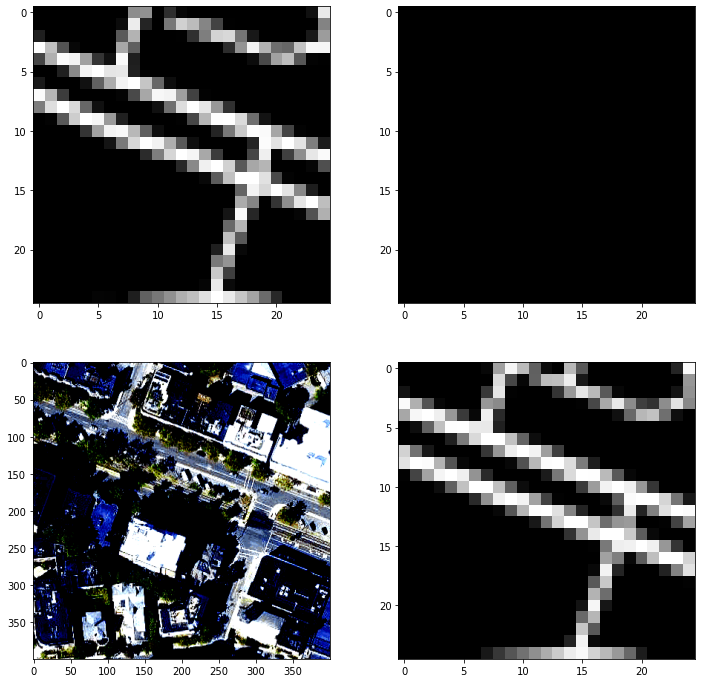

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
im = ax[0, 0].imshow(patched_input.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[0, 1].imshow(reconstructed.round().squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[1, 0].imshow(test_image.permute(1, 2, 0).detach().cpu().numpy())
im = ax[1, 1].imshow(patched_target.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')

plt.show()